<H2>I.1. Import des données du TRHAA</H2>

La base de données contient près de 18.220 enregistrements (résultats de recherche dans TRHAA), le processus de requête ne récupère que 10.000 enregistrements maximums et il est possible d’afficher des pages de 1.000 enregistrements. Nous avons donc utilisé plusieurs filtres partiels sur le champ « Université de soutenance » pour rester systématiquement en dessous de cette limite et récupérer l’exhaustivité des enregistrements.

## L'extraction des données
L'extraction des données a été faite avec l’outil Octoparse en version 8.6.2, avec le plan de souscription « Free ». Les extractions ont été réalisées par un traitement local sur un ordinateur Mac Book connecté au réseau Eduroam, sans utilisation de fonctionnalités avancées d’Octoparse (proxy, protection IP...). L’accès aux informations détaillées a été permis par l’utilisation d’un compte lecteur de la bibliothèque de l’INHA avec une carte d’étudiant et l’objet de la recherche.

## Les requêtes
Nous avons utilisé deux requêtes, une première pour récupérer la liste des URLs des pages de la base de données, la seconde pour récupérer sur chaque page l’ensemble des informations.

Filtre	# d’enregistrements
</p>* / France / Tout sauf Paris et Idf	7.411
</p>* / France / Paris et Idf / Tout sauf Panthéon Sorbonne Paris 1	6.335
</p>* / France / Paris et Idf / Panthéon Sorbonne Paris 1	4.414
</p>* / Non renseignés	57
</p>* / Italie, Suisse	3
</p>La page principale contient quelques informations (auteur, référence, titre) que l’on retrouve dans les informations détaillées en suivant les liens, ainsi que la date de dernière modification de la fiche (modifiée le).

In [40]:
# import des modules nécessaires
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from distinctipy import distinctipy
from matplotlib.font_manager import FontProperties
from matplotlib import rc
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import clear_output, display
from scipy.stats import chi2_contingency as chi2_contingency
import statsmodels.formula.api as statsapi
import statsmodels as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import xlrd as xlrd
from matplotlib import font_manager # for mac users
import platform
import os

# Modifier les paramètres d'affichage de la sortie des commandes dans Jupyter
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

# Pour lister les polices présentes
#fpaths = matplotlib.font_manager.findSystemFonts()
#for i in fpaths:
#    f = matplotlib.font_manager.get_font(i)
#    print(f.family_name)
# import de la police Garamond

system = platform.system()

if system == 'Darwin':  # macOS
  font_path = '/Library/Fonts/GaramondPremrPro.otf'
elif system == 'Windows':
  font_path = 'C:/Windows/Fonts/GARA.TTF'
else:  #  unix
  font_path = 'GARA.TTF'
print(font_path)

garamond_font = FontProperties(fname="/Library/Fonts/GaramondPremrPro.otf",size=14)
#    timesnewroman_font = FontProperties(fname="C:/Windows/Fonts/TIMES.TTF",size=14)

font_manager.findSystemFonts(fontpaths=font_path, fontext="ttf")
font_manager.findfont("Garamond Premier Pro") 

/Library/Fonts/Garamond Premier Pro.TTF


'/Library/Fonts/GaramondPremrPro.otf'

Récupération des données, 4 fichiers de données et 4 fichiers pour les url


In [4]:


df_data_temp_4414 = pd.read_excel("input/TRHAA/DATA for Fr_ParisIDF_Sorbonne_4414.xlsx", sheet_name=0)
df_data_temp_6335 = pd.read_excel("input/TRHAA/DATA for Fr_ParisIDF_TtSaufsorbonne_6335.xlsx", sheet_name=0)
df_data_temp_7411 = pd.read_excel("input/TRHAA/DATA for Fr_TtSaufParis_7411.xlsx",sheet_name=0)
df_data_temp_60 = pd.read_excel("input/TRHAA/DATA for TtSaufFrNonRenseignes_60.xlsx",sheet_name=0)

df_url_temp_6335 = pd.read_excel("input/TRHAA/URL_List_Fr_ParisIDF_TtSaufSorbonne_6335.xlsx",sheet_name=0)
df_url_temp_4414 = pd.read_excel("input/TRHAA/URL_List_Fr_ParisIDF_Sorbonne_4414.xlsx",sheet_name=0)
df_url_temp_7411 = pd.read_excel("input/TRHAA/URL_List_Fr_TtSaufParis_7411.xlsx",sheet_name=0)
df_url_temp_60 = pd.read_excel("input/TRHAA/URL_List_TtSaufFrance_NonRenseigne_60.xlsx",sheet_name=0)


Croisement des dataframe DATA et URL sur la clé "URL de la page" pour avoir l'ensemble des données pour chaque partie des données. Le nombre de colonnes est bien identique entre tous les fichiers (23)

In [5]:
# Merge des fichiers

# Column bind des logs et questionnaires
df_4414_temp = pd.merge(df_data_temp_4414, df_url_temp_4414,on=['Original_URL'],how='outer',suffixes=('','_url'))
df_6335_temp = pd.merge(df_data_temp_6335, df_url_temp_6335,on=['Original_URL'],how='outer',suffixes=('','_url'))
df_7411_temp = pd.merge(df_data_temp_7411, df_url_temp_7411,on=['Original_URL'],how='outer',suffixes=('','_url'))
df_60_temp = pd.merge(df_data_temp_60, df_url_temp_60,on=['Original_URL'],how='outer',suffixes=('','_url'))
print("Shape de df_4414_temp: ", df_4414_temp.shape)
print("shape de df_6335_temp: ", df_6335_temp.shape)
print("Shape de df_7411_temp: ", df_7411_temp.shape)
print("Shape de df_60_temp: ", df_60_temp.shape)


Shape de df_4414_temp:  (4414, 23)
shape de df_6335_temp:  (6335, 23)
Shape de df_7411_temp:  (7411, 23)
Shape de df_60_temp:  (60, 23)


Le nombre de lignes correspond aux nombres prévus on peut donc concaténer l'ensemble des dataframes et renommer les champs qui n'ont pas été correctement formatés lors de l'import.
On a 18220 lignes et 23 colonnes, toutes les données sont donc présentes.
</p></p>Tout est contenu dans le dataframe "df_trhaa_initial" qui conserve les données importées non modifiées.

In [6]:
# Concaténation des dataframes
df_tmp_1et2 = pd.concat([df_4414_temp,df_6335_temp], ignore_index=True)
df_tmp_3et4=pd.concat([df_7411_temp,df_60_temp], ignore_index=True)
df_trhaa_initial = pd.concat([df_tmp_1et2,df_tmp_3et4], ignore_index=True)

# Vérification du format
print("Shape de df_tmp: ", df_trhaa_initial.shape)

# Affichage des colonnes et renommage des colonnes ayant des noms génériques
df_trhaa_initial.rename(columns={"Field3": "ModifieLe","Field4": "NoticeAssocieeA"},inplace=True)
print("Colonnes: ", df_trhaa_initial.columns)


Shape de df_tmp:  (18220, 23)
Colonnes:  Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'ModifieLe',
       'NoticeAssocieeA'],
      dtype='object')


<H2>I.2. Qualité des données initiales</H2>

## Valeurs manquantes
On regarde maintenant si les champs ont des valeurs manquantes ou pas, les colonnes qui ne contiennent qu'une seule valeur et celles qui contiennent des valeurs distinctes.


In [24]:
# Info
df_trhaa_initial.info()

print("Données manquantes: \n" , df_trhaa_initial.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18220 entries, 0 to 18219
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Illustration                       18202 non-null  object        
 1   TypeDocument                       18202 non-null  object        
 2   TitreOuvrage                       18199 non-null  object        
 3   Ref_Complete                       17566 non-null  object        
 4   LangueDocument                     17981 non-null  object        
 5   RoleAuteurPrincipal                18194 non-null  object        
 6   TypeMemoire                        17966 non-null  object        
 7   AnneeSoutenance                    16051 non-null  object        
 8   SoutenanceDateDebut                18220 non-null  int64         
 9   SoutenanceDateFin                  18220 non-null  int64         
 10  AuteurPrincipal                   

## Matrice des valeurs manquantes des colonnes
Le graphique suivant montre la corrélation entre domaine de recherche et université, entre les champs des dates de soutenance, et montre l'absence de données pour les champs Indexation et Commentaires.</p>Les champs de début et de fin de soutenance pourront être complétés à partir du champ AnneeSoutenance.

<Axes: >

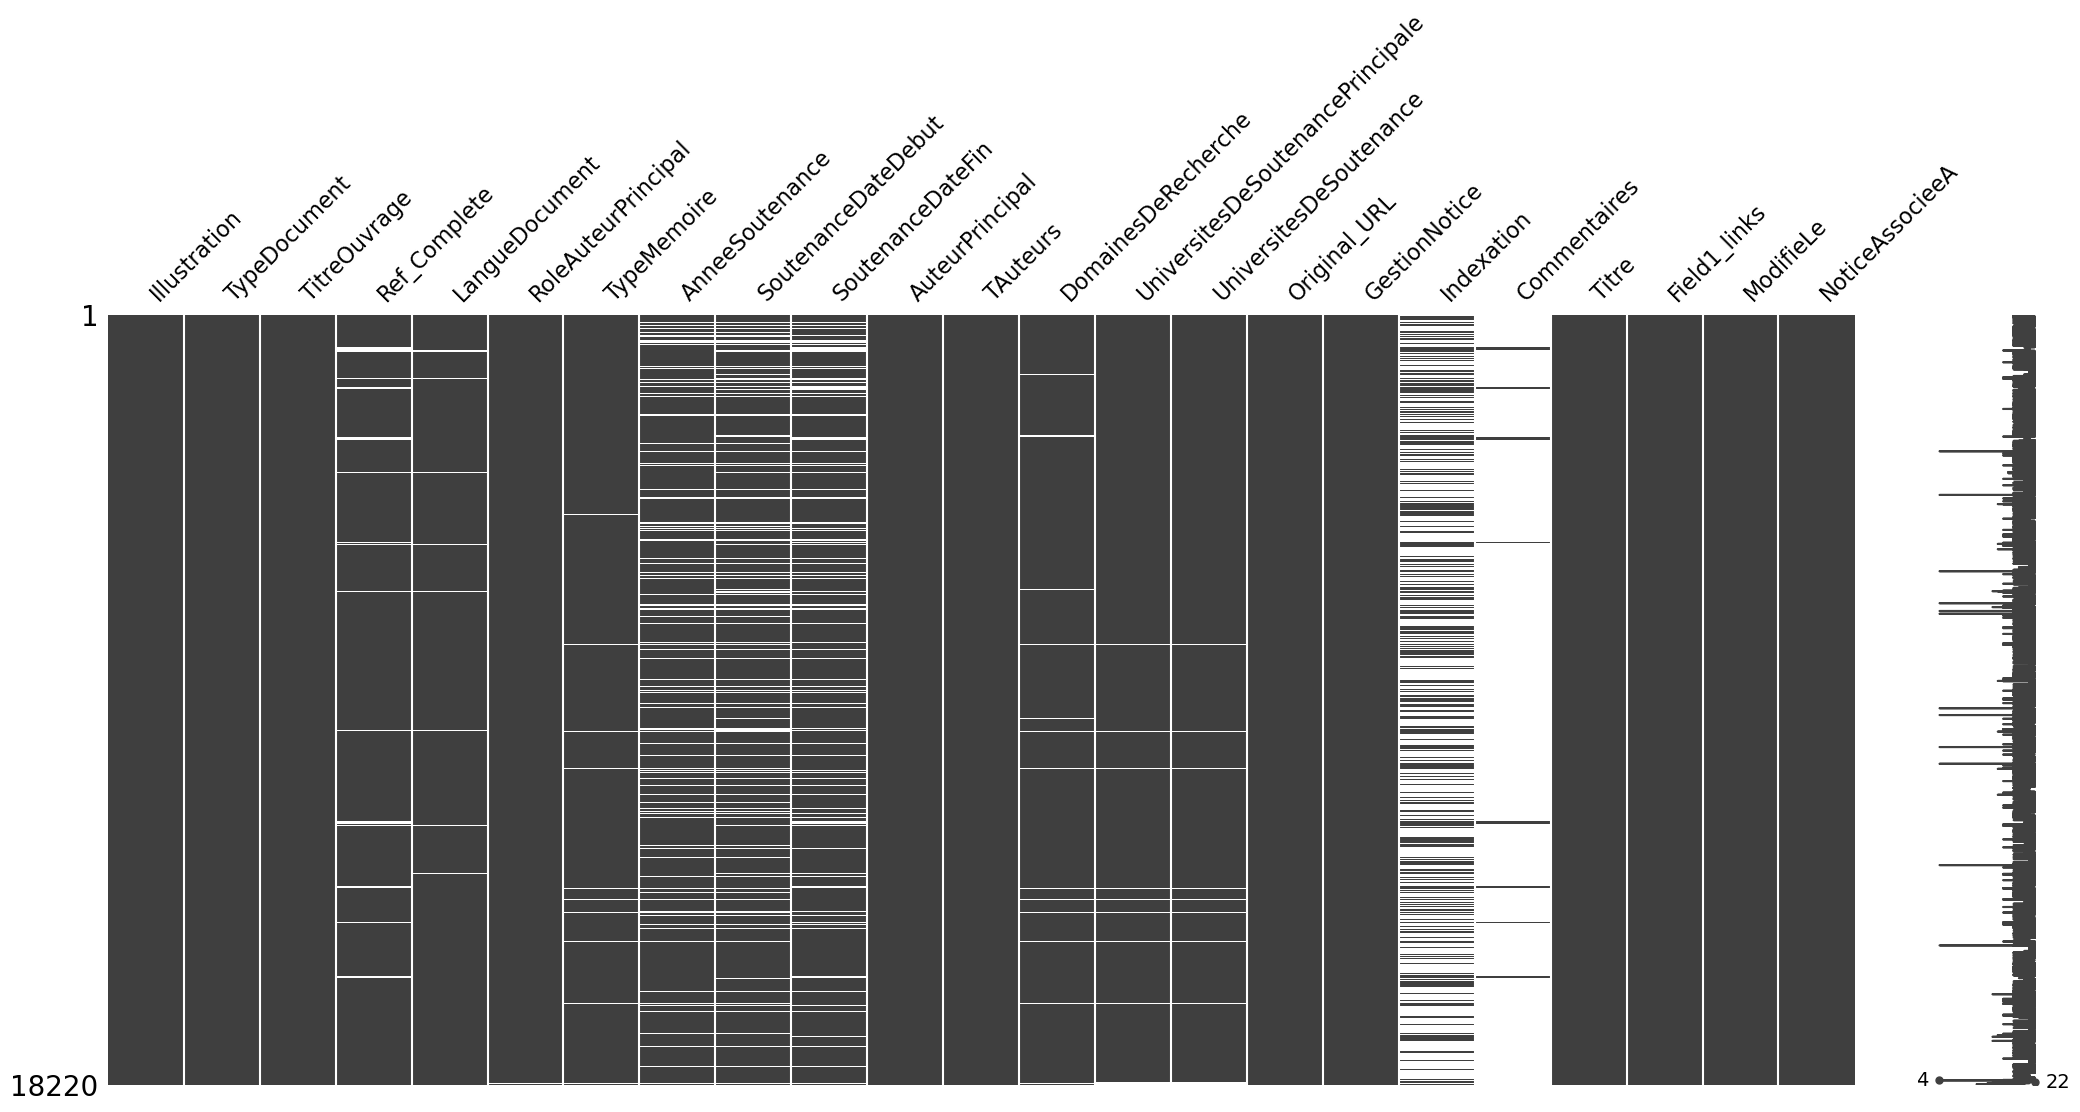

In [8]:
# Analyse colonnes
msno.matrix(df_trhaa_initial)

## Dendrogramme

Utilisation de la fonction Dendrogram de MSNO pour déterminer les corrélations dans le remplissage des champs du TRHAA

<Axes: >

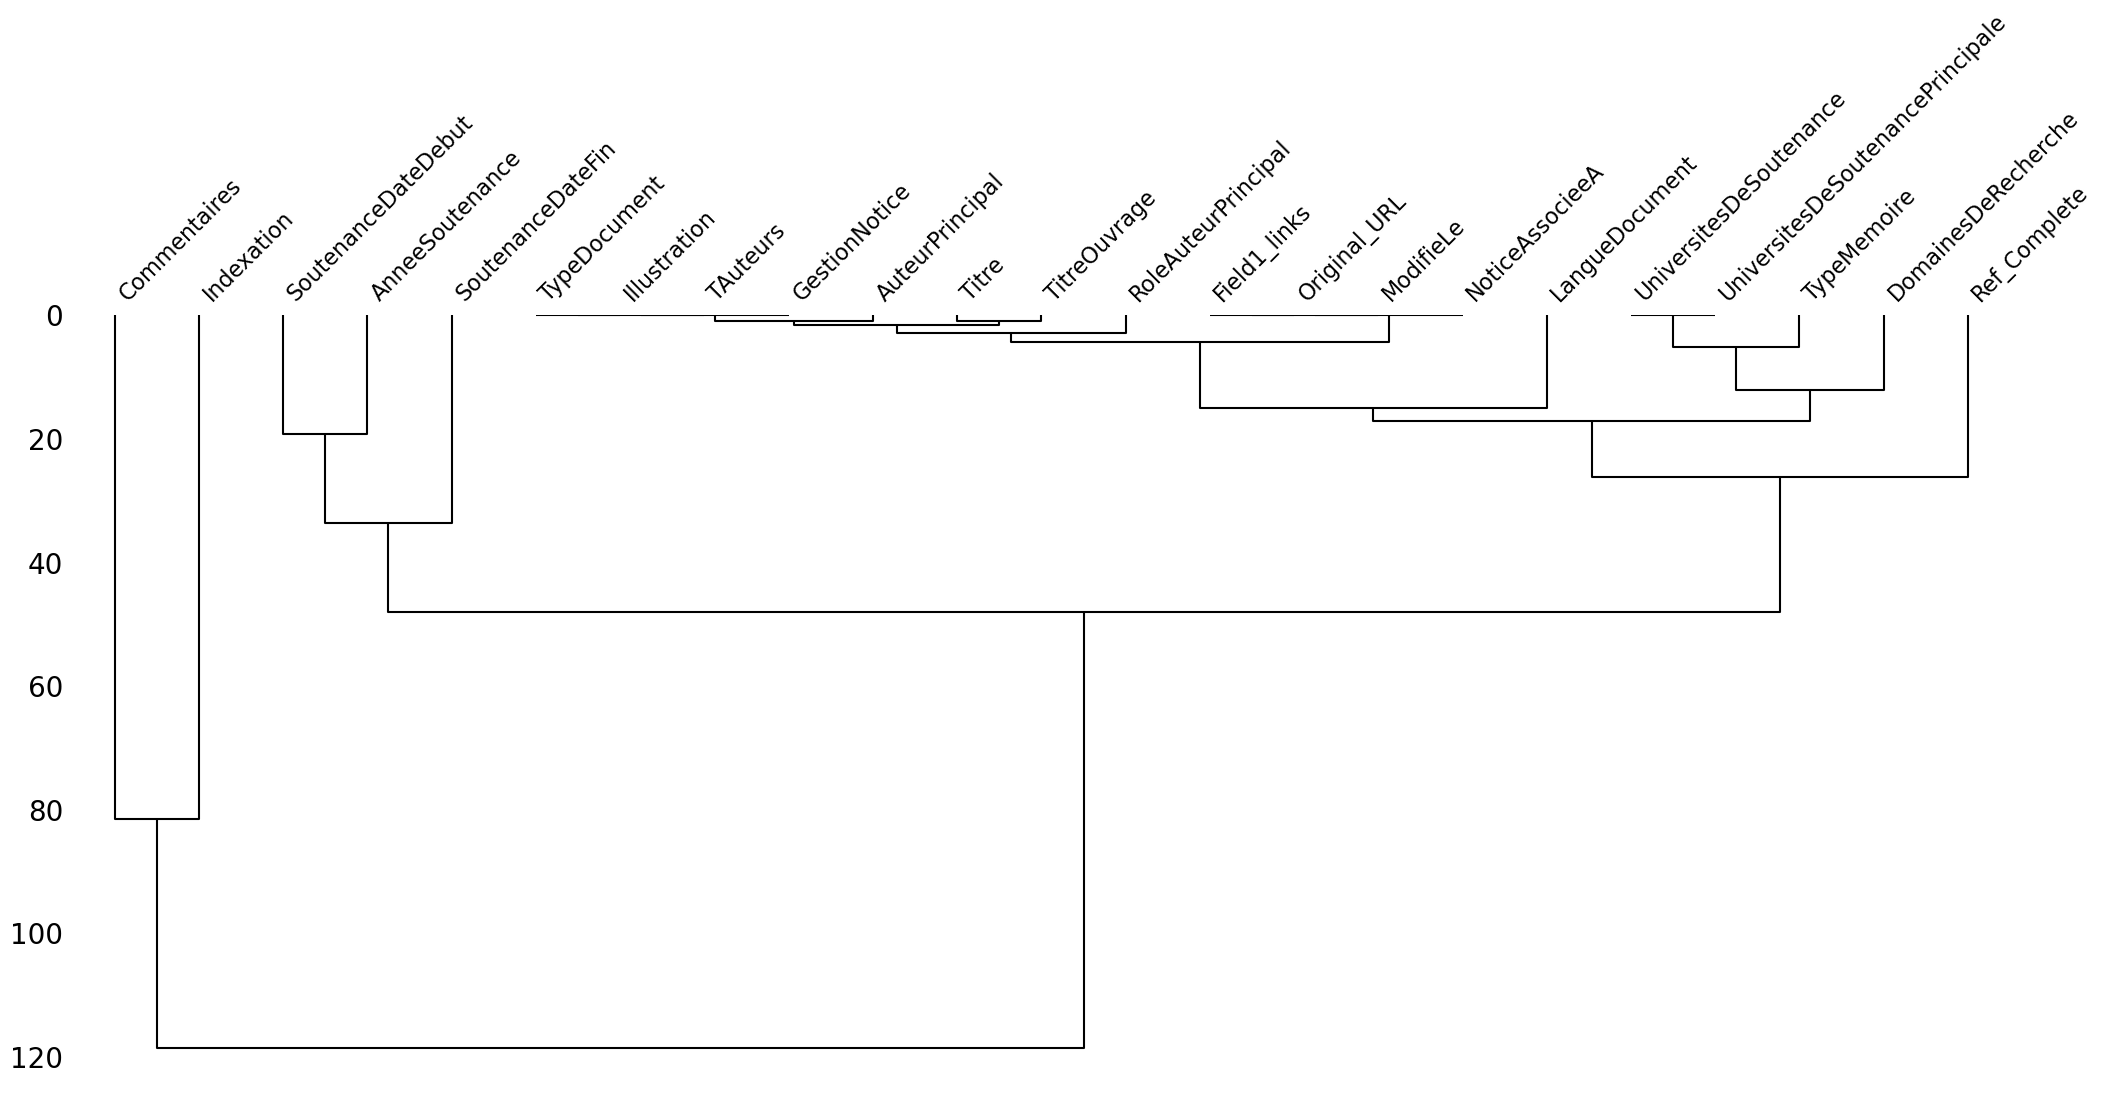

In [9]:
# Analyse colonnes
msno.dendrogram(df_trhaa_initial)

## Valeurs uniques, peu nombreuses et valeurs exclues du rapport
Le champ Illustration n'a qu'une seule valeur.
</p>Les champs TypeDocument, LangueDocument, RoleAuteurPrincipal, TypeMemoire, NoticeAssocieeA ont au maximum quelques dizaines de valeurs distinctes que nous étudierons plus en détail par la suite.
</p>Les champs NoticeAssocieeA, Indexation et Commentaires ne sont pas analysées dans le rapport.

In [10]:
# Find and display the unique values for each column
for column in df_trhaa_initial.columns:
    unique_count = df_trhaa_initial[column].nunique()
    unique_values = df_trhaa_initial[column].unique()
    print(f"Column '{column}' has {unique_count} unique values:")
    #print(unique_values)

Column 'Illustration' has 1 unique values:
Column 'TypeDocument' has 6 unique values:
Column 'TitreOuvrage' has 18108 unique values:
Column 'Ref_Complete' has 17562 unique values:
Column 'LangueDocument' has 5 unique values:
Column 'RoleAuteurPrincipal' has 3 unique values:
Column 'TypeMemoire' has 19 unique values:
Column 'AnneeSoutenance' has 136 unique values:
Column 'SoutenanceDateDebut' has 91 unique values:
Column 'SoutenanceDateFin' has 233 unique values:
Column 'AuteurPrincipal' has 15035 unique values:
Column 'TAuteurs' has 17050 unique values:
Column 'DomainesDeRecherche' has 1692 unique values:
Column 'UniversitesDeSoutenancePrincipale' has 76 unique values:
Column 'UniversitesDeSoutenance' has 87 unique values:
Column 'Original_URL' has 18215 unique values:
Column 'GestionNotice' has 139 unique values:
Column 'Indexation' has 5021 unique values:
Column 'Commentaires' has 6 unique values:
Column 'Titre' has 18109 unique values:
Column 'Field1_links' has 18215 unique values:


## Les types de documents
Le champ TypeDocument tout d'abord : on trouve quasiment exclusivement des mémoires (77,80%, 14169/18202) et des thèses (22,05%, 4015/18202).

In [11]:
# Visualisation des différentes valeurs de certains champs : TypeDocument, LangueDocument, RoleAuteurPrincipal, TypeMemoire

print(df_trhaa_initial.groupby(["TypeDocument"])["TypeDocument"].count().sort_values(ascending=False))

TypeDocument
mémoire                              14169
thèse                                 4015
ouvrage                                 11
DPLG                                     5
contribution à un ouvrage                1
travail personnel de fin d'études        1
Name: TypeDocument, dtype: int64


## Les types de documents suivant les cursus
Le champ TypeMemoire contient la liste des différents types de mémoire présents dans la base TRHAA.

In [118]:
print(df_trhaa_initial.groupby(["TypeMemoire"])["TypeMemoire"].count())

print("\nTotal: ", df_trhaa_initial.groupby(["TypeMemoire"])["TypeMemoire"].count().sum())


TypeMemoire
Habilitation à diriger des recherches                    61
Mémoire de 2e cycle de l'Ecole du Louvre                316
Mémoire de 3e cycle de l'Ecole du Louvre (Thèse)         91
Mémoire de DEA                                         1847
Mémoire de DESS                                           1
Mémoire de DRA                                           71
Mémoire de l'IFROA                                       62
Mémoire de master professionnel 1re année                32
Mémoire de master professionnel 2e année                139
Mémoire de master recherche 1re année                  4164
Mémoire de master recherche 2e année                   3214
Mémoire de maîtrise                                    4177
Mémoire de maîtrise de sciences et techniques (MST)      15
Thèse d'État                                              2
Thèse de 3e cycle                                         2
Thèse de doctorat                                        29
Thèse de l'Ecole des chartes

## Langue des documents

</p>La quasi totalité des documents sont rédigés en Français.

In [13]:
print(df_trhaa_initial.groupby(["LangueDocument"])["LangueDocument"].count().sort_values(ascending=False))

# Essentiellement des travaux en langue française

LangueDocument
Français     17973
Anglais          4
Allemand         2
Espagnol         1
Portugais        1
Name: LangueDocument, dtype: int64


## Les auteurs principaux
</p>Ils sont mentionnés (18182 sur 18202) quasiment tout le temps sauf une dizaine de fois où, très probablement, une erreur de saisie a mentionné le directeur de mémoire à la place. On peut confirmer, par exemple, que Philippe Dagen est un Professeur d'Histoire de l'art contemporain à Paris I et que Catherine Méneux est Maitresse de conférences depuis 2010 par exemple. Ils peuvent donc encadrer des thèses. <p>Dans tous les cas les auteurs principaux sont mentionnés dans les références complètes.
 

In [14]:
print(df_trhaa_initial.groupby(["RoleAuteurPrincipal"])["RoleAuteurPrincipal"].count())
print(df_trhaa_initial[df_trhaa_initial["RoleAuteurPrincipal"]=="directeur de mémoire"][["Ref_Complete","AuteurPrincipal"]])
print(df_trhaa_initial[df_trhaa_initial["RoleAuteurPrincipal"]=="directeur de thèse"][["Ref_Complete","AuteurPrincipal"]])

RoleAuteurPrincipal
auteur                  18182
directeur de mémoire       11
directeur de thèse          1
Name: RoleAuteurPrincipal, dtype: int64
                                            Ref_Complete       AuteurPrincipal
1321   Gallier, Valentine. La Fuite de Gradlon : entr...     Méneux, Catherine
1577   Posca, Francesca Romana. Les femmes dans les m...       Dagen, Philippe
1606   Gremel, Clémence. L’Estampe et l’affiche (1897...     Méneux, Catherine
1607   Ghnadour, Yasmine. En quête d’identité. La col...     Méneux, Catherine
3783   Langlois, Amandine. Patrimoine, politiques cul...     Méneux, Catherine
3784   Brault, Julie. Le périodique illustré Cocorico...        Gispert, Marie
3785   Garcia, Constance. Désaccord d’interprétation ...        Gispert, Marie
3792   Garden, Morgane. Les « cadres-souvenirs » des ...     Pernoud, Emmanuel
3793   Vasseur, Delphine. Les représentations de la f...     Méneux, Catherine
9131   Palmieri, Fiorella. Les Modistes parisiennes d...    

## Cohérence des données entre les champs TypeMémoire (thèses inscrites ou soutenues) et TypeDocument (thèses)

On souhaite vérifier l'adéquation entre les champs TypeDocument et TypeMémoire. On suppose qu'une thèse soutenue, et donc préalablement inscrite, n'est comptabilisée que comme thèse soutenue.
On pourra donc dans la partie du notebook consacrée à l'enrichissement"
1. Ajouter les champs TheseInscrite et TheseSoutenue sur le statut des thèses
2. Poursuivre avec la simplification des TypeMemoire, en particulier les thèses inscrites ou soutenues qui sont très probablement des thèses de doctorat.
<p>Les données sont conservées dans le dataframe df_trhaa_tmp</p>

In [15]:
# valeurs par défaut
df_trhaa_tmp = pd.DataFrame([])
df_trhaa_tmp["verifThese"] = df_trhaa_initial["TypeMemoire"]
df_trhaa_tmp["verifThese"] = ""

# parcours
for i in range(len(df_trhaa_initial["TypeMemoire"])):
    serieRow = df_trhaa_initial.iloc[i]
    itemTypeMemoire = serieRow.loc["TypeMemoire"]
    itemTypeDocument = serieRow.loc["TypeDocument"]
    if ((itemTypeMemoire == "Thèse inscrite") or (itemTypeMemoire == "Thèse soutenue")) and (itemTypeDocument == "thèse"):
        df_trhaa_tmp["verifThese"].iloc[i] = "thèse confirmée"
a = df_trhaa_tmp.groupby(["verifThese"])["verifThese"].count()

print("thèses confirmées: ", a[1])



thèses confirmées:  3729


In [16]:
# init
df_trhaa_tmp["verifNONThese"] = ""

# S'il s'agit d'un mémoire marqué thèse
for i in range(len(df_trhaa_initial["TypeMemoire"])):
    serieRow = df_trhaa_initial.iloc[i]
    itemTypeMemoire = serieRow.loc["TypeMemoire"]
    itemTypeDocument = serieRow.loc["TypeDocument"]
    #print("TypeMemoire: ", itemTypeMemoire, "TypeDocument: ", itemTypeDocument)
    if ((itemTypeMemoire != "Thèse inscrite") and 
        (itemTypeMemoire != "Thèse soutenue") and 
        (itemTypeMemoire != "Thèse de doctorat") and 
        (itemTypeMemoire != "Habilitation à diriger des recherches") and 
    (itemTypeDocument == "thèse")):
        df_trhaa_tmp["verifNONThese"].iloc[i] = "thèse NON confirmée"
a = df_trhaa_tmp.groupby(["verifNONThese"])["verifNONThese"].count()

print("mémoires non confirmés: ", a[1])

mémoires non confirmés:  196


## Les différents domaines de recherche

Il y a 58 domaines de recherches différents pour l'ensemble des 18000 fiches. Ce chiffre semble montrer que les entrées de la base de données sont contrôlées via un champ de sélection. Une catégorisation avec moins de valeurs différentes utilisant de plus larges domaines de recherches sera nécessaire pour rendre cette données exploitable.
Ce travail n'a pas été fait ici.</p>On liste pour information le nombre de document produit par domaine de recherche. Les données sont stockées dans le dataframe "df_trhaa_DomaineRecherche".

In [17]:
# lib
import re

#
df_trhaa_DomaineRecherche = pd.DataFrame([])
for i in range(len(df_trhaa_initial["DomainesDeRecherche"])):
    try:
        strDomainesComplets = df_trhaa_initial["DomainesDeRecherche"][i].split(":")
        strDomaines = strDomainesComplets[1:][0]
        lstDomaines = strDomaines[2:].split("\n")
        for j in range(len(lstDomaines)):
            strpDomaines = lstDomaines[j].strip()
            if len(strpDomaines) != 0:
                nouvelle_ligne = pd.DataFrame({'ListeDomaines': [strpDomaines]})
                df_trhaa_DomaineRecherche = pd.concat([df_trhaa_DomaineRecherche,nouvelle_ligne], ignore_index=True)
    except:
        strDomainesComplets = ""
    
df_trhaa_DomaineRecherche.reset_index()

print("Nb de domaines de recherche distincts: ",len(df_trhaa_DomaineRecherche.groupby("ListeDomaines")))
print("Domaines de recherche en référence: ",df_trhaa_DomaineRecherche.groupby(["ListeDomaines"])["ListeDomaines"].count().sum())
print("\n10 premiers domaines de recherche les plus référencés: \n\n",df_trhaa_DomaineRecherche.groupby(["ListeDomaines"])["ListeDomaines"].count().sort_values(ascending=False).head(10))

Nb de domaines de recherche distincts:  58
Domaines de recherche en référence:  24909

10 premiers domaines de recherche les plus référencés: 

 ListeDomaines
Art et archéologie du 20e-21e siècles                                           4991
Art et archéologie de la renaissance et des temps modernes (15e-18e siècles)    2477
Art et archéologie du 19e siècle                                                2047
Art et archéologie du moyen âge occidental                                      1955
Muséologie et étude des collections (publiques et privées)                      1569
Art et archéologie du proche et moyen Orient                                     948
Art et archéologie de la préhistoire-protohistoire                               942
Architecture                                                                     818
Histoire de l'histoire de l'art et de la critique d'art                          688
Art et archéologie de l'Italie et de Rome                                   

## Les universités de recherche
Il y a 76 universités distinctes. Nous avons regroupé par la suite les universités suivant 3 "régions" : Paris, Idf (Ile de France) et Province avec un champ additionnel.

In [18]:
# init
df_trhaa_Universites = pd.DataFrame([])

df_trhaa_Universites  =  df_trhaa_initial.groupby("UniversitesDeSoutenancePrincipale")["UniversitesDeSoutenancePrincipale"].count()
print("\nNb d'Universités distinctes: ", len(df_trhaa_Universites))
print("Top 10 de la production par universités: \n\n", df_trhaa_Universites.sort_values(ascending=False).head(10))


Nb d'Universités distinctes:  76
Top 10 de la production par universités: 

 UniversitesDeSoutenancePrincipale
Université Panthéon-Sorbonne - Paris I      4399
Université Paris-Sorbonne - Paris IV        3360
Ecole du Louvre                             1184
Université Lumière - Lyon II                 915
Université Paris-Nanterre                    886
Université Charles-de-Gaulle - Lille III     611
Université de Tours                          609
Université d'Aix-Marseille                   601
Université de Strasbourg                     535
Université de Poitiers                       507
Name: UniversitesDeSoutenancePrincipale, dtype: int64


## La gestion des notices

In [20]:
#
print(df_trhaa_initial.groupby("GestionNotice")["GestionNotice"].count())

GestionNotice
Gestion notice\n    \n        Base de données\n      Travaux de recherche en histoire de l'art et archéologie, TRHAA                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     3
Gestion notice\n    \n        Source\n      \n    Institut national d'histoire de l'art (France)\n  \n        Licence\n      \n    Attribution 4.0 International (CC BY 4.0)\n  \n        Base de données\n      Travaux de recherche en histoire de l'art et archéologie, TRHAA                                               

<H1>II. Enrichissement des données</H1>

<H2>II.1. Nouveaux champs</H2>

Le dataframe initial est dupliqué, on utilise désormais sa copie.

In [21]:
# copie du df_trhaa_initial vers df_trhaa pour conserver la version initiale telle quelle
df_trhaa = df_trhaa_initial

## Champ dtModifieLe au format datetime
Ajout d'une colonne avec la date de dernière modification au bon format datetime64

In [120]:
# Nouvelle colonne avec uniquement la date de dernière modification

df_trhaa[["Bla","DateModif"]] = df_trhaa.ModifieLe.str.split(":", expand=True)
df_trhaa["DateModif"] = df_trhaa["DateModif"].str.replace(' ','')
df_trhaa["dtModifieLe"] = pd.to_datetime(df_trhaa["DateModif"], format='%d/%m/%Y')
df_trhaa.drop(columns=["Bla","DateModif"], inplace=True)

#print(df_trhaa["dtModifieLe"])

# Groupby par Année et Mois
df_trhaa["nb_documents"] = ""
df_trhaa_groupedbydate = df_trhaa.groupby(["dtModifieLe"]).count().reset_index()
df_trhaa_groupedbydate = df_trhaa_groupedbydate.sort_values("dtModifieLe",ascending=True)
print("Quelques lignes de la distribution \n", df_trhaa_groupedbydate[["dtModifieLe","nb_documents"]])

# description de la distribution
print("Description de la distribution \n", df_trhaa_groupedbydate["nb_documents"].describe())

# on vérifie bien la somme de tous les nombres = 18202
print("Somme de tous les nombres \n", df_trhaa_groupedbydate["nb_documents"].sum())

Quelques lignes de la distribution 
     dtModifieLe  nb_documents
0    2018-07-04             1
1    2018-10-08             1
2    2019-01-04            25
3    2019-10-09             1
4    2019-12-05             3
..          ...           ...
97   2023-04-25             1
98   2023-05-03             1
99   2023-05-16             4
100  2023-05-17             1
101  2023-06-08             1

[102 rows x 2 columns]
Description de la distribution 
 count     102.000000
mean      178.627451
std      1082.415221
min         1.000000
25%         1.250000
50%         5.000000
75%        13.750000
max      8054.000000
Name: nb_documents, dtype: float64
Somme de tous les nombres 
 18220


## Champs SoutenanceDateDébut et Fin
* SoutenanceDateDebut
* SoutenanceDateFin
</p>On complète les champs SoutenanceDateDebut et SoutenanceDateFin à partir du champs Annee là où l'information est manquante. En général les deux dates sont identiques pour une référence donnée.

In [121]:
# Remplissage des champs SoutenanceDateDebut et Fin à partir de la colonne AnneeSoutenance

import re
pattern = r"(\d{4})(?:\s*-\s*(\d{4}))?"

for i in range(len(df_trhaa["AnneeSoutenance"])):
    ligne = df_trhaa["AnneeSoutenance"][i]
    if type(ligne) == str:
        matches = re.findall(pattern, ligne)
        for match in matches:
            # Si la deuxième date est absente, le groupe de capture 2 sera vide (None).
            # Vous pouvez le remplacer par une valeur par défaut si nécessaire.
            df_trhaa["SoutenanceDateDebut"][i] = match[0]
            df_trhaa["SoutenanceDateFin"][i] = match[1] if match[1] else match[0]  # Utilisez une valeur par défaut ici si nécessaire

# Convertit au format entier pour les années df.ID = pd.to_numeric(df.ID, errors='coerce').fillna(0).astype(np.int64)
df_trhaa.SoutenanceDateDebut = pd.to_numeric(df_trhaa.SoutenanceDateDebut,errors="coerce").fillna(0).astype(np.int64)
df_trhaa.SoutenanceDateFin = pd.to_numeric(df_trhaa.SoutenanceDateFin,errors="coerce").fillna(0).astype(np.int64)

print(df_trhaa[["AnneeSoutenance","SoutenanceDateDebut","SoutenanceDateFin"]].info())


/var/folders/8g/9w5gh8y54xd9jss52_tlythr0000gn/T/ipykernel_10445/1636685431.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trhaa["SoutenanceDateDebut"][i] = match[0]
/var/folders/8g/9w5gh8y54xd9jss52_tlythr0000gn/T/ipykernel_10445/1636685431.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trhaa["SoutenanceDateFin"][i] = match[1] if match[1] else match[0]  # Utilisez une valeur par défaut ici si nécessaire


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18220 entries, 0 to 18219
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AnneeSoutenance      16051 non-null  object
 1   SoutenanceDateDebut  18220 non-null  int64 
 2   SoutenanceDateFin    18220 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.2+ KB
None


In [122]:
print("Nombre de dates de début de soutenance",df_trhaa_initial["SoutenanceDateDebut"].count())
print("Nombre de dates de fin de soutenance",df_trhaa_initial["SoutenanceDateFin"].count())

Nombre de dates de début de soutenance 18220
Nombre de dates de fin de soutenance 18220


## Champs TheseInscrite et TheseSoutenue

In [123]:
# valeurs par défaut
df_trhaa["TheseInscrite"] = "False"
df_trhaa["TheseSoutenue"] = "False"

# maj sous conditions
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Thèse inscrite", "TheseInscrite"] = "True"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Thèse soutenue", "TheseSoutenue"] = "True"


## Champ TypeMemoireThese

Pour nous permettre par la suite d'analyser les parcours universitaires des étudiants nous simplifions le champ TypeMemoire :
* Mémoires : M2 recherche, M2 Pro, M1 Recherche, M1 Pro
* Thèses : Thèse de 3e cycle, HDR, Thèse de doctorat

In [124]:
# valeurs par défaut
df_trhaa["TypeMemoireThese"] = np.nan
df_trhaa.reset_index()

# maj sous conditions # thèses
df_trhaa.loc[df_trhaa_initial["TypeMemoire"] == "Thèse inscrite", "TypeMemoireThese"] = "These de doctorat"
df_trhaa.loc[df_trhaa_initial["TypeMemoire"] == "Thèse soutenue", "TypeMemoireThese"] = "These de doctorat"
df_trhaa.loc[df_trhaa_initial["TypeMemoire"] == "Thèse d'État", "TypeMemoireThese"] = "These de doctorat"
df_trhaa.loc[df_trhaa_initial["TypeMemoire"] == "Thèse de l'Ecole des chartes", "TypeMemoireThese"] = "These de 3e cycle"
df_trhaa.loc[df_trhaa_initial["TypeMemoire"] == "Thèse de 3e cycle", "TypeMemoireThese"] = "These de 3e cycle"

# maj sous conditions # mémoires
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Habilitation à diriger des recherches", "TypeMemoireThese"] = "HDR"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de 2e cycle de l'Ecole du Louvre", "TypeMemoireThese"] = "M2 Recherche"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de 3e cycle de l'Ecole du Louvre (Thèse)", "TypeMemoireThese"] = "These de 3e cycle"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de DEA", "TypeMemoireThese"] = "M2 Recherche"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de DESS", "TypeMemoireThese"] = "M2 Pro"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de DRA", "TypeMemoireThese"] = "M2 Pro"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de l'IFROA", "TypeMemoireThese"] = "M2 Pro" # M2 plutôt que M1 car clôt un cycle
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de master professionnel 1re année", "TypeMemoireThese"] = "M1 Pro"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de master professionnel 2e année", "TypeMemoireThese"] = "M2 Pro"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de master recherche 1re année", "TypeMemoireThese"] = "M1 Recherche"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de master recherche 2e année", "TypeMemoireThese"] = "M2 Recherche"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de maîtrise", "TypeMemoireThese"] = "M1 Recherche"
df_trhaa.loc[df_trhaa["TypeMemoire"] == "Mémoire de maîtrise de sciences et techniques (MST)", "TypeMemoireThese"] = "M2 Pro"

print(df_trhaa[["Illustration","TypeMemoireThese"]].groupby("TypeMemoireThese")["TypeMemoireThese"].count())

print("Total: ", df_trhaa[["Illustration","TypeMemoireThese"]].groupby("TypeMemoireThese")["TypeMemoireThese"].count().sum())


TypeMemoireThese
HDR                    61
M1 Pro                 32
M1 Recherche         8341
M2 Pro                288
M2 Recherche         5377
These de 3e cycle     104
These de doctorat    3734
Name: TypeMemoireThese, dtype: int64
Total:  17937


## Champ RefPage (Clé Primaire)

</p>Ajout d'une clé primaire. Il est construit à partir du champ Field1_links et contient une référence unique à chaque page.

In [29]:
from urllib.parse import urlparse

# valeurs par défaut
df_trhaa["refPage"] = np.nan

# décomposition de Field1_links
for ligne in range(len(df_trhaa["Field1_links"])):
    #print(df_trhaa_initial["Field1_links"][ligne])
    path = urlparse(df_trhaa["Field1_links"][ligne]).path
    df_trhaa["refPage"][ligne] = path.split('/')[-1]

print(df_trhaa["refPage"].head(3))

/var/folders/8g/9w5gh8y54xd9jss52_tlythr0000gn/T/ipykernel_10445/1600523824.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trhaa["refPage"][ligne] = path.split('/')[-1]


0    c89d05f4-f622-409d-9f1e-eede55803f3a
1    7280af88-ff65-43ed-8b94-ff94e3686180
2    0537482c-b996-43f6-bd0c-b622a6de31c7
Name: refPage, dtype: object


## Champ UniversiteRegion

Ajout d'un champ pour la région à laquelle appartient l'université : Paris, Idf, Province

In [30]:
# ajout d'une colonne Paris / Province
df_trhaa["UniversiteRegion"] = "Province"

#
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Panthéon-Sorbonne - Paris I", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Paris-Sorbonne - Paris IV", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole du Louvre", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Paris-Nanterre", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole pratique des hautes études", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole des hautes études en sciences sociales", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Sorbonne Université", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université de Versailles-Saint-Quentin-en-Yvelines", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Paris-Diderot - Paris VII", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Vincennes-Saint-Denis - Paris VIII", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université Sorbonne-Nouvelle - Paris III", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Institut d'études politiques de Paris", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole pratique des hautes études - PSL", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole normale supérieure", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université de Cergy-Pontoise", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Institut Catholique de Paris", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Université de Paris", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Paris-Belleville", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Paris-Malaquais", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Paris-Est", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Paris-Val de Seine", "UniversiteRegion"] = "Paris"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Versailles", "UniversiteRegion"] = "Idf"
df_trhaa.loc[df_trhaa["UniversitesDeSoutenancePrincipale"] == "Ecole nationale supérieure d'architecture de Paris-La Villette", "UniversiteRegion"] = "Paris"

df_trhaa_groupedby_UniversiteRegion = df_trhaa.groupby("UniversiteRegion").count().reset_index()
df_trhaa_groupedby_UniversiteRegion.rename(columns={"Illustration":"NbUnivRegion"}, inplace=True)
print(df_trhaa_groupedby_UniversiteRegion[["UniversiteRegion","NbUnivRegion"]])

  UniversiteRegion  NbUnivRegion
0              Idf           966
1            Paris          9525
2         Province          7711


## Champs Prenom et Genre

</p>On récupère un fichier des prénoms téléchargé depuis le site gouv.fr et croisé avec nos données afin de pouvoir ensuite produire des statistiques sur le genre.

In [31]:
# import du fichier prénom nat2021
df_datagouv_PG = pd.read_excel("input/TRHAA/nat2021.xlsx", sheet_name=0)
df_datagouv_PG.rename(columns={"preusuel":"PrenomAuteur","sexe":"Genre"},inplace=True)
df_datagouv_PG.replace({1:"Homme",2:"Femme"},inplace=True)
print(df_datagouv_PG.columns)
print(df_datagouv_PG.index)

Index(['Genre', 'PrenomAuteur', 'annais', 'nombre'], dtype='object')
RangeIndex(start=0, stop=686538, step=1)


In [32]:
df_datagouv_PG.reset_index
print(df_datagouv_PG)

        Genre    PrenomAuteur annais nombre
0       Homme  _PRENOMS_RARES   1900   1249
1       Homme  _PRENOMS_RARES   1901   1342
2       Homme  _PRENOMS_RARES   1902   1330
3       Homme  _PRENOMS_RARES   1903   1286
4       Homme  _PRENOMS_RARES   1904   1430
...       ...             ...    ...    ...
686533  Femme           ZYNEB   2018      5
686534  Femme           ZYNEB   2019      7
686535  Femme           ZYNEB   2020      8
686536  Femme           ZYNEB   2021      6
686537  Femme           ZYNEB   XXXX     19

[686538 rows x 4 columns]


In [33]:
# init. P Prenom, G Genre

# découpage du prénom et du nom du fichier trhaa. 
df_trhaa["PrenomAuteur"] = df_trhaa_initial.AuteurPrincipal.str.split(",", expand=True)[1]
df_trhaa["PrenomAuteur"] = df_trhaa["PrenomAuteur"].str.strip()
df_trhaa["PrenomAuteur"] = df_trhaa["PrenomAuteur"].str.upper()

# groupby du fichier des prénoms sur PrenomAuteur et Sexe
df_grouped_datagouv_PG = df_datagouv_PG.groupby(["PrenomAuteur","Genre"],as_index=False).size()

print(df_trhaa.shape)
print(df_grouped_datagouv_PG.shape)

# merge
df_trhaa_PG = pd.merge(df_trhaa, df_grouped_datagouv_PG, on="PrenomAuteur", how="left")

# affichage
print("info: ",df_trhaa_PG.shape)
print("info: ",df_trhaa_PG.columns)


(18220, 31)
(38478, 3)
info:  (25207, 33)
info:  Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'ModifieLe',
       'NoticeAssocieeA', 'dtModifieLe', 'nb_documents', 'TheseInscrite', 'TheseSoutenue',
       'TypeMemoireThese', 'refPage', 'UniversiteRegion', 'PrenomAuteur', 'Genre', 'size'],
      dtype='object')


<H2>II.2. Suppression des champs inutilisés</H2>

In [34]:
# Nettoyage des DF

df_trhaa.drop(  columns=["nb_documents2",
                        "Illustration",
                        "TitreOuvrage",
                        "Ref_complete",
                        "LangueDocument",
                        "RoleAuteurPrincipal",
                        "TAuteurs",
                        "GestionNotice",
                        "Indexation",
                        "Commentaires",
                        "Titre",
                        "NoticeAssocieeA"
                        ],
                inplace=False,
                errors="ignore")
print(df_trhaa.columns)


Index(['Illustration', 'TypeDocument', 'TitreOuvrage', 'Ref_Complete', 'LangueDocument',
       'RoleAuteurPrincipal', 'TypeMemoire', 'AnneeSoutenance', 'SoutenanceDateDebut',
       'SoutenanceDateFin', 'AuteurPrincipal', 'TAuteurs', 'DomainesDeRecherche',
       'UniversitesDeSoutenancePrincipale', 'UniversitesDeSoutenance', 'Original_URL',
       'GestionNotice', 'Indexation', 'Commentaires', 'Titre', 'Field1_links', 'ModifieLe',
       'NoticeAssocieeA', 'dtModifieLe', 'nb_documents', 'TheseInscrite', 'TheseSoutenue',
       'TypeMemoireThese', 'refPage', 'UniversiteRegion', 'PrenomAuteur'],
      dtype='object')


<H1>III. Visualisation des données</H1>

<H2>III.1 Dynamique de la base TRHAA</H2>
<H4>III.1.1 Le champ dtModifieLe comme marqueur de l'insertion des enregistrements</H4>
<p>Peut-on utiliser la date de modification comme une date d'insertion dans la base TRHAA afin d'analyser le dynamisme de mise à jour. Après analyse ce champ ne convient pas.


In [35]:
# Groupby par Année et Mois
df_trhaa["nb_documents"] = df_trhaa[["Illustration"]].copy()
df_trhaa_groupedbydate = df_trhaa.groupby(["dtModifieLe"]).count().reset_index()
df_trhaa_groupedbydate = df_trhaa_groupedbydate.sort_values("dtModifieLe",ascending=True)
print("Quelques lignes de la distribution \n", df_trhaa_groupedbydate[["dtModifieLe","nb_documents"]])

# description de la distribution
print("Description de la distribution \n", df_trhaa_groupedbydate["nb_documents"].describe())

# on vérifie bien la somme de tous les nombres = 18202
print("Somme de tous les nombres \n", df_trhaa_groupedbydate["nb_documents"].sum())



Quelques lignes de la distribution 
     dtModifieLe  nb_documents
0    2018-07-04             1
1    2018-10-08             1
2    2019-01-04            25
3    2019-10-09             1
4    2019-12-05             3
..          ...           ...
97   2023-04-25             1
98   2023-05-03             1
99   2023-05-16             4
100  2023-05-17             1
101  2023-06-08             1

[102 rows x 2 columns]
Description de la distribution 
 count     102.000000
mean      178.450980
std      1081.427784
min         1.000000
25%         1.250000
50%         5.000000
75%        13.750000
max      8046.000000
Name: nb_documents, dtype: float64
Somme de tous les nombres 
 18202


<p>Distribution des dates</p>
</p>Il y a 102 dates de modification différentes. Cela semble peu par rapport au nombre de lignes dans les données sources.

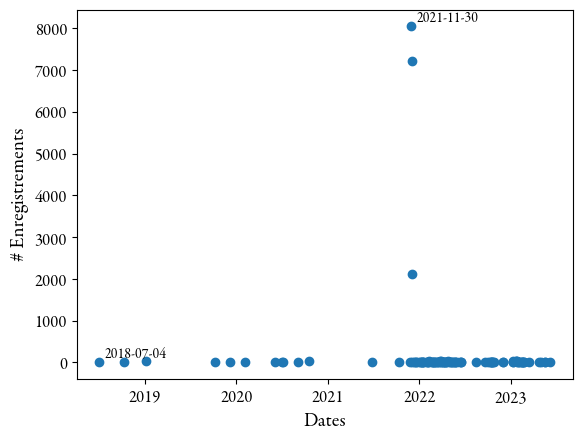

In [48]:
# lib
from datetime import datetime
#dtpoint = datetime("%d-%m-%Y")

# Afficher la distribution du nombre de documents
fig,ax = plt.subplots()

#df_trhaa_grouped.scatterplot( df_trhaa_grouped["dtModifieLe"], df_trhaa_grouped["nb_documents"])
ax.scatter(df_trhaa_groupedbydate["dtModifieLe"], df_trhaa_groupedbydate["nb_documents"])
dtpoint1 = datetime.strptime("2018-07-04", "%Y-%m-%d")
dtpoint8046 = datetime.strptime("2021-11-30", "%Y-%m-%d")
ax.annotate("2018-07-04", xy=(dtpoint1,1), xytext = (5,5), textcoords = "offset pixels", font=garamond_font, fontsize=10)
ax.annotate("2021-11-30", xy=(dtpoint8046,8046), xytext = (5,5), textcoords = "offset pixels", font=garamond_font, fontsize=10)
#plt.title("Distribution dans le temps des dates de modifications des enregistrements")
plt.xlabel("Dates", fontsize=14, font=garamond_font)
plt.xticks(font=garamond_font,fontsize=12)
plt.yticks(font=garamond_font,fontsize=12)
plt.ylabel("# Enregistrements", font=garamond_font,fontsize=14)
plt.show()

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.,  9000.]),
 [Text(0, -1000.0, '−1000'),
  Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000'),
  Text(0, 7000.0, '7000'),
  Text(0, 8000.0, '8000'),
  Text(0, 9000.0, '9000')])

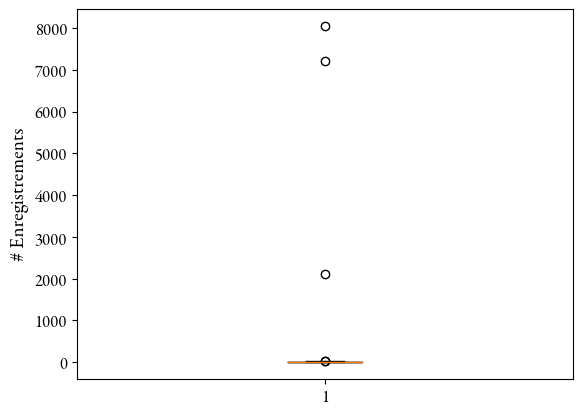

In [51]:
# Afficher

plt.boxplot(df_trhaa_groupedbydate["nb_documents"])
#plt.title("Boxplot de la distribution")
plt.ylabel("# Enregistrements", fontsize=14, font=garamond_font)
plt.xticks(font=garamond_font,fontsize=12)
plt.yticks(font=garamond_font,fontsize=12)

### Conclusion : 
Les enregistrements devraient être faits année après année, à la suite des déclarations des enseignants. Ici on voit que distribution de ce champ n'est pas régulière du tout. Une mise à jour massive a été réalisée en 2022. Il faudrait pouvoir disposer d'un champ spécifique.

<H4>III.1.2 Date de soutenance</H4>
</p>Quel champ utiliser pour les dates de soutenance, SoutenanceDateDebut ou Fin ? Existe t-il des différences entre les champs date de début de soutenance et date de fin de soutenance ? La réponse est non à 86% (16051/18220), on utilisera par la suite la date de fin de soutenance.

In [52]:
# init
df_comp_dates = pd.DataFrame([])

# Comparaison des champs
df_comp_dates["Resultat_Comp"] = (df_trhaa["SoutenanceDateDebut"]==df_trhaa["SoutenanceDateDebut"])
#print(df_comp_dates.reset_index())
print("Info: ",df_comp_dates.info())
print("index: ",df_comp_dates.index)
print("Cols: ",df_comp_dates.columns)
#print("colonnes: ",df_comp_dates.info(), "\n")
print("Nb de valeurs identiques: ", df_comp_dates["Resultat_Comp"].sum())
print("Nb de valeurs totales: ", df_comp_dates["Resultat_Comp"].count())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18220 entries, 0 to 18219
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Resultat_Comp  18220 non-null  bool 
dtypes: bool(1)
memory usage: 17.9 KB
Info:  None
index:  RangeIndex(start=0, stop=18220, step=1)
Cols:  Index(['Resultat_Comp'], dtype='object')
Nb de valeurs identiques:  18220
Nb de valeurs totales:  18220


Etant donné que nous n'avons pas la date d'insertion des enregistrements dans la base mais seulement la date de dernière modification.

## Conclusion: 
Nous faisons l'approximation que la date de fin de soutenance correspond à la date d'insertion à un an près et les dates de début et de fin de soutenance sont similaires. Dans la suite de cette étude nous utiliserons la date de fin de soutenance uniquement pour suivre l'évolution dans le temps de différents indicateurs.

<H2>III.3.Productions du TRHAA</H2>
<H4>III.3.1 Productions des mémoires et thèses dans le TRHAA</H4>
</p>Combien les étudiants ont réalisés de mémoires ou de thèses, toutes filières confondues, toutes universités confondues ?

In [54]:
# init
df_trhaa["NbDocParEtudiant"] = 0

# afficher la distribution des # de documents (mémoires & thèses) par étudiant si >=2
df_trhaa_groupbyNbdoc = df_trhaa[["AuteurPrincipal","Illustration"]].groupby(["AuteurPrincipal"]).count().sort_values("Illustration",ascending=False).reset_index()
df_trhaa_groupbyNbdoc.rename(columns={'Illustration':'NbDeDocs'},inplace=True)
print(df_trhaa_groupbyNbdoc[df_trhaa_groupbyNbdoc["NbDeDocs"]>=2])
print("Nb de doc = 1, ", df_trhaa_groupbyNbdoc[df_trhaa_groupbyNbdoc["NbDeDocs"]==1]["NbDeDocs"].count())


        AuteurPrincipal  NbDeDocs
0     Méneux, Catherine         5
1        Haguet, Lucile         4
2     Fenech, Antonella         4
3      Lhermite, Xavier         4
4     Theuninck, Ingrid         4
...                 ...       ...
2741  Tavernari, Cinzia         2
2742      Bodet, Cédric         2
2743   Bonnetot, Céline         2
2744    Bolle, Gauthier         2
2745      Tequi, Pierre         2

[2746 rows x 2 columns]
Nb de doc = 1,  12289


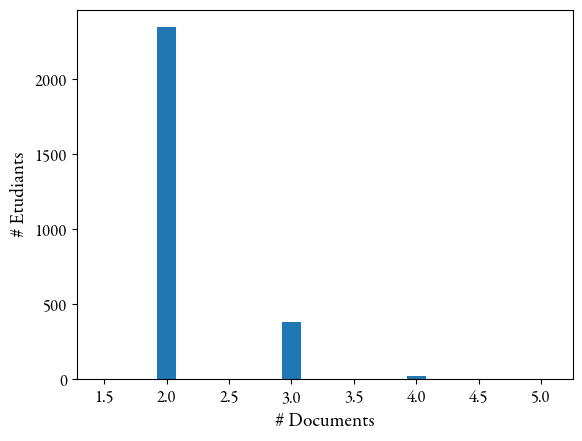

In [57]:
# Afficher la distribution du nombre de documents
fig,ax = plt.subplots()
bins=(1.5,2,3,4,5,6)
#df_trhaa_grouped.scatterplot( df_trhaa_grouped["dtModifieLe"], df_trhaa_grouped["nb_documents"])
#print(df3.describe())
ax.hist(df_trhaa_groupbyNbdoc[df_trhaa_groupbyNbdoc["NbDeDocs"]>=2]["NbDeDocs"],bins=bins, align="left",rwidth=0.15)
#plt.title("# d'étudiants ayant publiés au moins 2 documents")
plt.xlabel("# Documents",  font=garamond_font, fontsize=14)
plt.ylabel("# Etudiants", font=garamond_font, fontsize=14)
plt.xticks(font=garamond_font,fontsize=12)
plt.yticks(font=garamond_font,fontsize=12)
plt.show()

<H4>III.3.2 Evolution des productions de Thèses et Mémoires</H4>
</p>

In [106]:
# filtre sur les années 1950 à 2023
df_trhaa_PG_2000_2023 = df_trhaa_PG[(df_trhaa_PG["SoutenanceDateFin"]>=1950) & (df_trhaa_PG["SoutenanceDateFin"]<=2024)]
df_trhaa_PG_2000_2023 = df_trhaa_PG_2000_2023.sort_values("SoutenanceDateFin",ascending=True)

# regrouper les données par Année et TypeDocument, et compter les résultats
df_trhaa_PG_grouped = df_trhaa_PG_2000_2023.groupby(["SoutenanceDateFin","TypeDocument"],as_index=False).count()

# affichage du dataframe, qques colonnes pour vérifier le format
df_trhaa_PG_grouped.rename(columns={"Illustration":"nb_docs"},inplace=True)
df_trhaa_PG_groupedforpivot = df_trhaa_PG_grouped[["SoutenanceDateFin","TypeDocument","nb_docs"]]
# affichage des colonnes pour le graphique

df_trhaa_PG_groupedforpivot = df_trhaa_PG_groupedforpivot[ df_trhaa_PG_groupedforpivot["TypeDocument"].isin(["thèse","mémoire"])]
print(df_trhaa_PG_groupedforpivot)

     SoutenanceDateFin TypeDocument  nb_docs
0                 1953        thèse        2
1                 1961        thèse        1
2                 1962      mémoire        1
3                 1963        thèse        2
4                 1964        thèse        2
..                 ...          ...      ...
107               2021      mémoire      203
108               2021        thèse        2
109               2022      mémoire      182
110               2022        thèse        5
111               2023      mémoire        9

[105 rows x 3 columns]


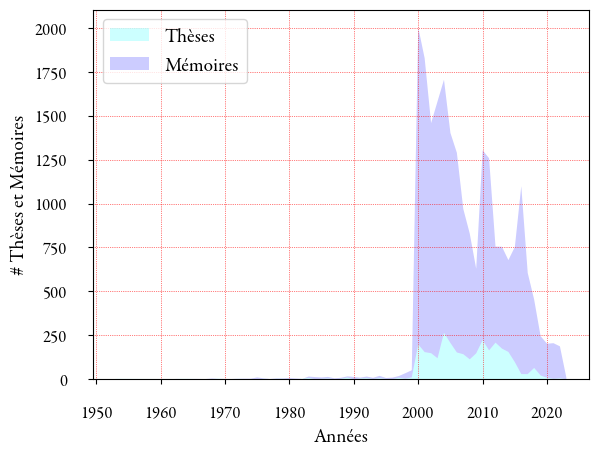

In [107]:
# affichage de l'evolution des # de mémoires et thèses dans le temps
df_trhaa_PG_pivot = pd.DataFrame([])

# pivot
df_trhaa_PG_pivot = pd.pivot_table(df_trhaa_PG_groupedforpivot,index="TypeDocument",values="nb_docs",columns="SoutenanceDateFin")
df_trhaa_PG_pivot = df_trhaa_PG_pivot.fillna(0)
df_trhaa_PG_pivot =df_trhaa_PG_pivot.T.reset_index()

# fabrication des listes pour stackplot
category = df_trhaa_PG_pivot["SoutenanceDateFin"].tolist()
values = df_trhaa_PG_pivot[[   "thèse","mémoire"
                ]].values.T.tolist()
labels = ["Thèses", "Mémoires"]
colors = ["cyan","blue"]

# affichage du stackplot
plt.stackplot(category,*values,labels=labels,colors=colors, alpha=0.2)
matplotlib.rc('font',family='Garamond Premier Pro')
plt.legend(loc='upper left', prop={'size':14})
#plt.title("Evolution des thèses et mémoires dans TRHAA",size=20)
plt.xlabel("Années", fontsize=14,font=garamond_font)
plt.ylabel("# Thèses et Mémoires",fontsize=14,font=garamond_font)
plt.tick_params(axis='x', pad=15)
plt.tick_params(axis='y', pad=15)
plt.xticks(font=garamond_font,fontsize=12)
plt.yticks(font=garamond_font,fontsize=12)
plt.grid(True)
plt.grid(color='red', linestyle=':', linewidth=0.5,alpha=1)
plt.show()

On remarque qu'il y a un nombre résiduel de mémoires et thèses avant l'an 2000. Les informations insérées dans TRHAA datent pour la plupart de 1998-2000. On réduit donc la plage de temps pour la visualisation

In [112]:
# filtre sur les années 1995 à 2023
df_trhaa_PG_1995_2023 = df_trhaa_PG[(df_trhaa_PG["SoutenanceDateFin"]>=1995) & (df_trhaa_PG["SoutenanceDateFin"]<=2024)]
df_trhaa_PG_1995_2023 = df_trhaa_PG_1995_2023.sort_values("SoutenanceDateFin",ascending=True)

# regrouper les données par Année et TypeMémoire, et compter les résultats
df_trhaa_PG_grouped = df_trhaa_PG_1995_2023.groupby(["SoutenanceDateFin","TypeMemoireThese"],as_index=False).count()
df_trhaa_PG_grouped["nb_cursus"] = df_trhaa_PG_grouped["Illustration"].copy()

# affichage du dataframe, qques colonnes pour vérifier le format
df_trhaa_PG_groupedforpivot = df_trhaa_PG_grouped[["SoutenanceDateFin","TypeMemoireThese","nb_cursus"]]
# affichage des colonnes pour le graphique
print(df_trhaa_PG_groupedforpivot)#

     SoutenanceDateFin   TypeMemoireThese  nb_cursus
0                 1995       M2 Recherche          3
1                 1996       M1 Recherche          1
2                 1996       M2 Recherche          2
3                 1997       M1 Recherche          4
4                 1997  These de doctorat          3
..                 ...                ...        ...
133               2022       M1 Recherche        112
134               2022       M2 Recherche         69
135               2022  These de doctorat          4
136               2023       M1 Recherche          2
137               2023       M2 Recherche          7

[138 rows x 3 columns]


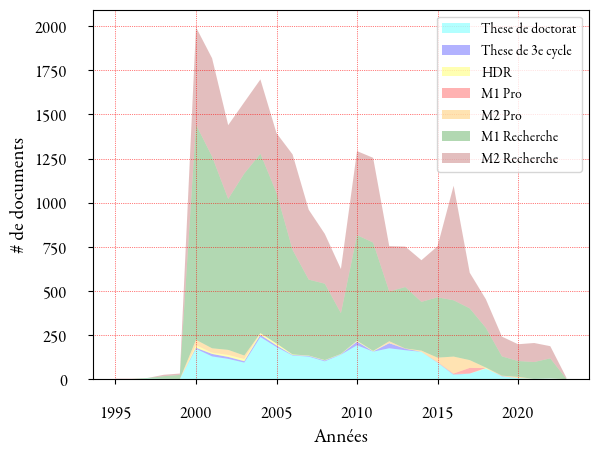

In [125]:
# Evolution des # des différents cursus dans le temps
df_trhaa_PG_pivot = pd.DataFrame([])

# pivot
df_trhaa_PG_pivot = pd.pivot_table(df_trhaa_PG_groupedforpivot,index="TypeMemoireThese",values="nb_cursus",columns="SoutenanceDateFin")
df_trhaa_PG_pivot = df_trhaa_PG_pivot.fillna(0)
df_trhaa_PG_pivot =df_trhaa_PG_pivot.T.reset_index()

# fabrication des listes pour stackplot
category = df_trhaa_PG_pivot["SoutenanceDateFin"].tolist()
values = df_trhaa_PG_pivot[[    "These de doctorat",
                                "These de 3e cycle",
                                "HDR",
                                "M1 Pro",
                                "M2 Pro",
                                "M1 Recherche",
                                "M2 Recherche"
                            ]].values.T.tolist()
labels = [  "These de doctorat",
            "These de 3e cycle",
            "HDR",
            "M1 Pro",
            "M2 Pro",
            "M1 Recherche",
            "M2 Recherche"
            ]
colors = ["cyan","blue", "yellow", "red","orange","green","brown"]

# affichage du stackplot
plt.stackplot(category,*values,labels=labels,colors=colors, alpha=0.3)
plt.legend(loc='upper right')
#plt.title("Filières relatives aux documents dans TRHAA",size=20)
plt.xlabel("Années", fontsize=14, font=garamond_font)
plt.ylabel("# de documents", fontsize=14, font=garamond_font)
plt.tick_params(axis='x', pad=15)
plt.tick_params(axis='y', pad=15)
plt.xticks(font=garamond_font,fontsize=12)
plt.yticks(font=garamond_font,fontsize=12)
plt.grid(True)
plt.grid(color='red', linestyle=':', linewidth=0.5,alpha=1)
plt.show()


## Conclusion:
Il y a peu de report dans TRHAA : il y a par exemple 154 étudiants reçus en Master 2 à l'Ecole du Louvre en 2021 donc à priori 154 mémoires de M2 Recherche, (voir https://www.ecoledulouvre.fr/sites/default/files/pdf/ssdossier1/RAP2021_pourInternet.pdf page 14) alors que la figure suivante nous montre environ 130 mémoires de M2 toutes filières d'Histoire de l'art confondues.

<H4>III.3.2 Evolution des différentes filières</H4>

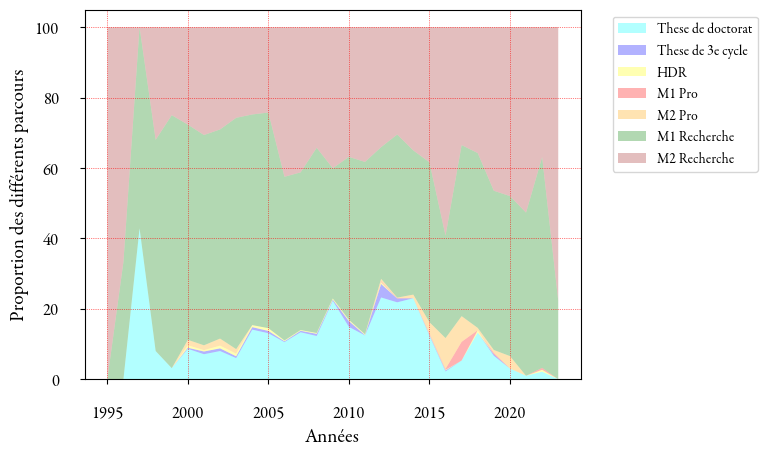

In [128]:
# Evolution des # des différents cursus dans le temps
df_trhaa_PG_pivot = pd.DataFrame([])

# pivot
df_trhaa_PG_pivot = pd.pivot_table(df_trhaa_PG_groupedforpivot,index="TypeMemoireThese",values="nb_cursus",columns="SoutenanceDateFin")
df_trhaa_PG_pivot = df_trhaa_PG_pivot.fillna(0)
df_trhaa_PG_pivot =df_trhaa_PG_pivot.T.reset_index()
#print(df_trhaa_PG_pivot)
# fabrication des listes pour stackplot

# ajouter une colonne total de toutes les colonnes
df_trhaa_PG_pivot["Total"] = df_trhaa_PG_pivot[[    "These de doctorat",
                                                    "These de 3e cycle",
                                                    "HDR",
                                                    "M1 Pro",
                                                    "M2 Pro",
                                                    "M1 Recherche",
                                                    "M2 Recherche"
                                                ]].sum(axis=1)

# ajouter des colonnes avec value / somme_colonne * 100
df_trhaa_PG_pivot["M2_Recherche_100"] = 100 * df_trhaa_PG_pivot["M2 Recherche"] / df_trhaa_PG_pivot["Total"]
df_trhaa_PG_pivot["M1_Pro_100"] = 100 * df_trhaa_PG_pivot["M1 Pro"] / df_trhaa_PG_pivot["Total"]
df_trhaa_PG_pivot["M2_Pro_100"] = 100 * df_trhaa_PG_pivot["M2 Pro"] / df_trhaa_PG_pivot["Total"]
df_trhaa_PG_pivot["These_100"] = 100 * df_trhaa_PG_pivot["These de doctorat"] / df_trhaa_PG_pivot["Total"]
df_trhaa_PG_pivot["HDR_100"] = 100 * df_trhaa_PG_pivot["HDR"] / df_trhaa_PG_pivot["Total"]
df_trhaa_PG_pivot["These_3_100"] = 100 * df_trhaa_PG_pivot["These de 3e cycle"] / df_trhaa_PG_pivot["Total"]
df_trhaa_PG_pivot["M1_Recherche_100"] = 100 * df_trhaa_PG_pivot["M1 Recherche"] / df_trhaa_PG_pivot["Total"]

category = df_trhaa_PG_pivot["SoutenanceDateFin"].tolist()
values = df_trhaa_PG_pivot[[    "These_100",
                                "These_3_100",
                                "HDR_100",
                                "M1_Pro_100",
                                "M2_Pro_100",
                                "M1_Recherche_100",
                                "M2_Recherche_100"
                ]].values.T.tolist()

df_trhaa_PG_pivot["Total_100"] = df_trhaa_PG_pivot[[    "These_100",
                                                        "These_3_100",
                                                         "HDR_100",
                                                        "M1_Pro_100",
                                                        "M2_Pro_100",
                                                        "M1_Recherche_100",
                                                        "M2_Recherche_100"
                                                        ]].sum(axis=1)

colors = ["cyan","blue", "yellow", "red","orange","green","brown"]

labels = [  "These de doctorat",
            "These de 3e cycle",
            "HDR",
            "M1 Pro",
            "M2 Pro",
            "M1 Recherche",
            "M2 Recherche"
            ]

# affichage du stackplot
plt.stackplot(category,*values,labels=labels,colors=colors, alpha=0.3)
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
#plt.title("Evolution des différentes filières dans TRHAA",size=20)
plt.xlabel("Années", fontsize=14,font=garamond_font)
plt.ylabel("Proportion des différents parcours",fontsize=14,font=garamond_font)
plt.tick_params(axis='x', pad=15)
plt.tick_params(axis='y', pad=15)
plt.xticks(font=garamond_font,fontsize=12)
plt.yticks(font=garamond_font,fontsize=12)
plt.grid(True)
plt.grid(color='red', linestyle=':', linewidth=0.5,alpha=1)
plt.show()


## Conclusion:
tbd

## Influence de la Région et du Genre sur le nombre de thèses et de mémoires

Si l'on affiche la répartition des thèses ou des mémoires en fonction du genre et de la région on observe que :
- l'Ile de France est très peu représentée malgré plusieurs universités comme Nanterre, Versailles Saint-Quentin, Vincennes Saint-Denis et Cergy-Pontoise
- la proportion de femmes est un peu supérieures à celle des hommes, quelle que soit la région

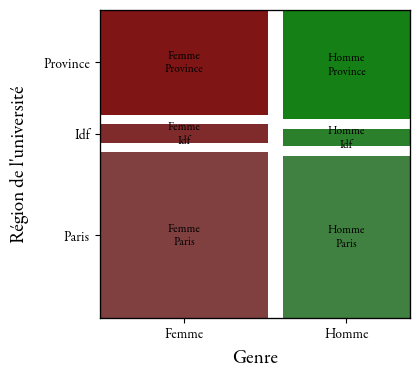

In [90]:
# Afficher les sur et sous représentation (cf mosaic rapport stats)

# Mosaic plot sans résidus
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.contingency_tables import Table
import matplotlib.pyplot as plt

# Create a new figure with a defined size
fig, ax = plt.subplots(figsize=(4, 4))

# Sélection des thèses uniquement
df_trhaa_PG_these = df_trhaa_PG[df_trhaa_PG["TypeMemoireThese"]=="These de doctorat"]

# Create the mosaic plot
mosaic(df_trhaa_PG_these, ['Genre','UniversiteRegion'],  gap=0.05, ax=ax, statistic=False)

# Customize the plot
#plt.title('Proportions des thèses en fonction de la région et du genre', fontsize=15)
ax.set_ylabel("Région de l'université", rotation=90, labelpad=10, fontsize=14,font=garamond_font)
ax.set_xlabel("Genre",rotation=0, labelpad=5,fontsize=14,font=garamond_font)
plt.xticks(font=garamond_font,fontsize=12)
plt.yticks(font=garamond_font,fontsize=12)
plt.show()

In [ ]:
# Test du CHI2
 
# Les données, pivot_table
df_trhaa_pivot_Region_Gender = df_trhaa_PG_these[["UniversiteRegion","Genre"]].pivot_table(index="UniversiteRegion", columns="Genre", aggfunc=len).fillna(0).copy()
print("table pivot \n", df_trhaa_pivot_Region_Gender)

# Chi2 contingency
(chi2, p_value, dof, exp) = chi2_contingency(df_trhaa_pivot_Region_Gender)
print("stats_chi2 ", chi2)
print("dof ", dof)
print("p_value ", p_value)

table pivot 
 Genre             Femme  Homme
UniversiteRegion              
Idf                  34     26
Paris              1428   1043
Province            838    654
stats_chi2  1.0085371059864574
dof  2
p_value  0.60394716925531


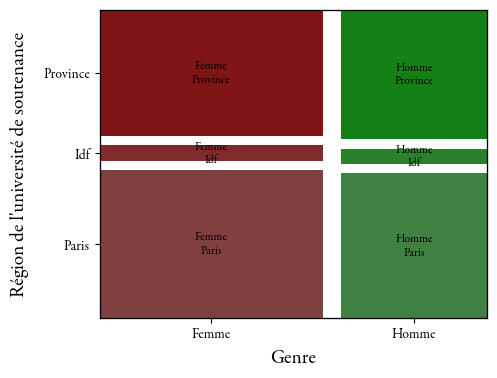

In [104]:
# Afficher les sur et sous représentation (cf mosaic rapport stats)

# Mosaic plot sans résidus
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.contingency_tables import Table
import matplotlib.pyplot as plt

# Create a new figure with a defined size
fig, ax = plt.subplots(figsize=(5,4))

# Sélection des mémoires uniquement
df_trhaa_PG_memoire = df_trhaa_PG[df_trhaa_PG["TypeMemoireThese"].isin(["M1 Recherche","M2 Recherche","M1 Pro","M2 Pro"])]

# Create the mosaic plot
mosaic(df_trhaa_PG_memoire, ['Genre','UniversiteRegion'], gap=0.05, ax=ax, statistic=False)


# Customize the plot
#plt.title('Proportions des mémoires en fonction de la région et du genre', fontsize=15, y=1.1)
#plt.xlabel('Genre')
#plt.ylabel("Région de l'Université de soutenance")
ax.set_ylabel("Région de l'université de soutenance", rotation=90, labelpad=10, font=garamond_font,fontsize=14)
ax.set_xlabel("Genre",rotation=0, labelpad=5, font=garamond_font,fontsize=14)
plt.xticks(font=garamond_font,fontsize=12)
plt.yticks(font=garamond_font,fontsize=12)
plt.show()



In [ ]:
# Test du CHI2
 
# Les données, pivot_table
df_trhaa_pivot_Region_Gender = df_trhaa_PG_memoire[["UniversiteRegion","Genre"]].pivot_table(index="UniversiteRegion", columns="Genre", aggfunc=len).fillna(0).copy()
print("table pivot \n", df_trhaa_pivot_Region_Gender)

# Chi2 contingency
(chi2, p_value, dof, exp) = chi2_contingency(df_trhaa_pivot_Region_Gender)
print("stats_chi2 ", chi2)
print("dof ", dof)
print("p_value ", p_value)

table pivot 
 Genre             Femme  Homme
UniversiteRegion              
Idf                  16     14
Paris              5254   3357
Province           4084   2741
stats_chi2  2.846060534015253
dof  2
p_value  0.24098266753790518


## Conclusion:
La répartition des thèses ou des mémoires en fonction du genre et de la région montre que :
- l'Ile de France est très peu représentée malgré plusieurs universités comme Nanterre, Versailles Saint-Quentin, Vincennes Saint-Denis et Cergy-Pontoise : elles représentent peu d'étudiants et il y a probablement peu de report dans TRHAA
- la proportion de femmes est un peu supérieures à celle des hommes, quelle que soit la région mais pour les mémoires comme pour les thèses il y a peu d'influence du genre sur l'indicateur. (Mémoires chi2=2.84, p=0.24. Thèses chi2=1, p=0.60). L'influence est plus importante pour les mémoires que pour les thèses mais les valeurs de chi2 restent très faibles et les p_values largement au-dessus de 5%. On ne peut pas rejeter l'hypothèse nulle et l'absence d'influence par le Genre

<H4>III.3.3 Mouvement intra-régions entre Mémoires et Thèses</H4>
</p>Un certain nombre d'étudiants ont suivi un parcours complet de recherche, incluant un master 2 et une thèse de doctorat. Dans quelle la proportion les étudiants sont restés dans la même région pour suivre ce parcours. Les régions sont classées en 3 groupes principaux : Paris, Ile de France (Idf) et Province.

In [ ]:
# dataframe pour tester l'affichage

dict = {    "Etudiant_ID":("Etudiant_1","Etudiant_2","Etudiant_3"),
            "RegionUnivMemoire":("Paris","Paris","Province"),
            "RegionUnivThese":("Paris","Idf","Paris")
        }
df_test = pd.DataFrame(dict)

df_test["MemeRegionMT"] = df_test["RegionUnivMemoire"] == df_test["RegionUnivThese"]
df_test["MemeUnivMT"] = False
print(df_test)

  Etudiant_ID RegionUnivMemoire RegionUnivThese  MemeRegionMT  MemeUnivMT
0  Etudiant_1             Paris           Paris          True       False
1  Etudiant_2             Paris             Idf         False       False
2  Etudiant_3          Province           Paris         False       False


In [ ]:
# Résultat, il y a 33% des étudiants qui restent dans la même région pour faire leur mémoire et leur thèse, et 66% qui changent de région.


In [ ]:
# filtre sur les années 1950 à 2023
#print(df_trhaa_PG.columns)
df_trhaa_PG_2000_2023 = df_trhaa_PG[(df_trhaa_PG["SoutenanceDateFin"]>=1950) & (df_trhaa_PG["SoutenanceDateFin"]<=2024)]
df_trhaa_PG_2000_2023 = df_trhaa_PG_2000_2023.sort_values("SoutenanceDateFin",ascending=True)

# regrouper les données par Auteur Principal, et compter les résultats
df_trhaa_PG_grouped = df_trhaa_PG_2000_2023.groupby(["AuteurPrincipal","TypeDocument","UniversiteRegion"]).count().reset_index()
print(df_trhaa_PG_grouped[["TypeDocument","AuteurPrincipal","UniversiteRegion"]])

# Nouvelles colonnes mémoire et thèse
df_trhaa_PG_grouped["Memoire"] = False
df_trhaa_PG_grouped["These"] = False
df_trhaa_PG_grouped["RegionMemoire"] = ""
df_trhaa_PG_grouped["RegionThese"] = ""
df_trhaa_PG_grouped["MRegion"] = False

for i in range(len(df_trhaa_PG_grouped["AuteurPrincipal"])):
    if df_trhaa_PG_grouped["TypeDocument"][i] == "mémoire":
        df_trhaa_PG_grouped["Memoire"] = True
        df_trhaa_PG_grouped["RegionMemoire"] = df_trhaa_PG_grouped["UniversiteRegion"]
    if df_trhaa_PG_grouped["TypeDocument"][i] == "thèse":
        df_trhaa_PG_grouped["These"] = True
        df_trhaa_PG_grouped["RegionThese"] = df_trhaa_PG_grouped["UniversiteRegion"]
df_trhaa_PG_grouped.drop_duplicates(subset=["AuteurPrincipal","Memoire","These"],inplace=True)
df_trhaa_PG_grouped["MRegion"] = df_trhaa_PG_grouped["RegionMemoire"] == df_trhaa_PG_grouped["RegionThese"]
print("Meme Region: ", df_trhaa_PG_grouped["MRegion"].count())
print(df_trhaa_PG_grouped[["AuteurPrincipal","Memoire","These","MRegion", "RegionThese","RegionMemoire"]])

# affichage du dataframe, qques colonnes pour vérifier le format
#df_trhaa_PG_grouped.rename(columns={"Illustration":"nb_docs"},inplace=True)
#df_trhaa_PG_groupedforpivot = df_trhaa_PG_grouped[["SoutenanceDateFin","TypeDocument","nb_docs"]]
# affichage des colonnes pour le graphique
#print(df_trhaa_PG_grouped[["SoutenanceDateFin","TypeDocument","nb_docs"]])
#print(df_trhaa_PG_groupedforpivot)
#df_trhaa_PG_groupedforpivot = df_trhaa_PG_groupedforpivot[ df_trhaa_PG_groupedforpivot["TypeDocument"].isin(["thèse","mémoire"])]
#print(df_trhaa_PG_groupedforpivot)

      TypeDocument               AuteurPrincipal UniversiteRegion
0          mémoire             Aallouche, Sabine         Province
1          mémoire                  Abad, Elodie         Province
2          mémoire                  Abadie, Aude         Province
3          mémoire  Abadie-Hosseinabadi, Shahram              Idf
4            thèse  Abadie-Hosseinabadi, Shahram         Province
...            ...                           ...              ...
14228      mémoire          de Filippis, Antoine            Paris
14229        thèse               kolářová, Petra            Paris
14230      mémoire                kshanti Gamage         Province
14231      mémoire               Étienne, Audrey         Province
14232      mémoire                 Özcan, Zeliha         Province

[14233 rows x 3 columns]
Meme Region:  13674
                    AuteurPrincipal  Memoire  These  MRegion RegionThese RegionMemoire
0                 Aallouche, Sabine     True   True     True    Province   

In [ ]:
# Indexation, modalités

print(df_trhaa_initial.groupby("Indexation").count())

                                                    Illustration  TypeDocument  TitreOuvrage  \
Indexation                                                                                     
Indexation\n    \n        Indexations\n      \n...             1             1             1   
Indexation\n    \n        Indexations\n      \n...             1             1             1   
Indexation\n    \n        Indexations\n      \n...             1             1             1   
Indexation\n    \n        Indexations\n      \n...             1             1             1   
Indexation\n    \n        Indexations\n      \n...             1             1             1   
...                                                          ...           ...           ...   
Indexation\n      \n        Indexations\n      ...             1             1             1   
Indexation\n      \n        Indexations\n      ...             1             1             1   
Indexation\n      \n        Indexations\

## Conclusion:
tbd